In [29]:
from imblearn.over_sampling import SMOTE
import sklearn as sk
from sklearn.neural_network import MLPClassifier
import random as rnd
import matplotlib.pyplot as plt
import joblib

In [121]:
df[df.columns != 'country']

,Inactive,country,last_year,sector,pnl,pnl_lag,assets,assets_lag,fixed_assets,curr_assets,...,FI,FR,IT,NO,NL,AT,IS,CY,SE,LU
0,0,BE,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,0,BE,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0,BE,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,0,BE,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,0,BE,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271596,1,SE,2018,Retail,28.0,-74,807,110,766,41.0,...,0,0,0,0,0,0,0,0,1,0
271597,1,SE,2019,Business Services,54.0,248,376,3694,24,352.0,...,0,0,0,0,0,0,0,0,1,0
271598,1,SE,2019,"Travel, Personal & Leisure",54.0,-38,858,59,685,173.0,...,0,0,0,0,0,0,0,0,1,0
271599,1,SE,2019,"Travel, Personal & Leisure",46.0,56,116,194,51,65.0,...,0,0,0,0,0,0,0,0,1,0


In [69]:
%run -i src/data_preproc.py

Reading file: orbis_active_be.xlsx ...
Reading file: orbis_active_de.xlsx ...
Reading file: orbis_active_dk.xlsx ...
Reading file: orbis_active_es.xlsx ...
Reading file: orbis_active_fin.xlsx ...
Reading file: orbis_active_fra.xlsx ...
Reading file: orbis_active_it.xlsx ...
Reading file: orbis_active_no.xlsx ...
Reading file: orbis_active_rest.xlsx ...
Reading file: orbis_active_se.xlsx ...
Reading file: orbis_default.xlsx ...


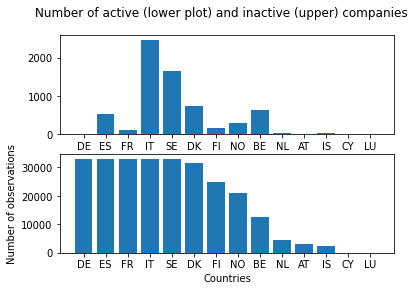

In [70]:
barplot_df = (df
            .groupby('country')['Inactive']
            .agg([('n_inactive', lambda x: np.sum(x == 1)), 
                  ('n_active', lambda x: np.sum(x == 0))]).\
            pipe(lambda df: df.assign(inactive_share = lambda column: column.n_inactive / (column.n_active + column.n_inactive)))
            .reset_index()
            .sort_values(by='n_active', ascending=False))

fig, axs = plt.subplots(2)
fig.suptitle('Number of active (lower plot) and inactive (upper) companies')
axs[0].bar(barplot_df.country, barplot_df.n_inactive)
axs[1].bar(barplot_df.country, barplot_df.n_active)
plt.xlabel("Countries")
plt.ylabel("Number of observations")
plt.savefig('latex/img/country_n.png', dpi=150)

In [109]:
df.columns

Index(['Inactive', 'country', 'last_year', 'sector', 'pnl', 'pnl_lag',
       'assets', 'assets_lag', 'fixed_assets', 'curr_assets', 'capital',
       'lt_debt', 'curr_liab', 'cash', 'revenue', 'revenue_lag', 'ebit',
       'ebit_lag', 'ebit_ratio1', 'ebit_ratio2', 'ebit_ratio3', 'pnl_ratio1',
       'liab_ratio1', 'curr_assets_ratio1', 'revenue_ratio1', 'capital_ratio1',
       'pnl_ratio2', 'pnl_ratio3', 'liab_ratio2', 'pnl_ratio4',
       'curr_liab_ratio1', 'assets_log', 'liab_ratio3', 'curr_liab_ratio2',
       'revenue_ratio2', 'revenue_ratio3', 'curr_assets_ratio2',
       'capital_ratio2', 'liab_ratio4', 'revenue_ratio4', 'revenue_ratio5',
       'curr_assets_ratio3', 'revenue_ch', 'pnl_ch', 'assets_ch', 'ebit_ch',
       'capital_ratio3', 'sector_0', 'sector_1', 'sector_2', 'sector_3',
       'sector_4', 'sector_5', 'sector_6', 'sector_7', 'sector_8', 'sector_9',
       'sector_10', 'sector_11', 'sector_12', 'sector_13', 'sector_14',
       'sector_15', 'sector_16', 'sector_17

<AxesSubplot:>

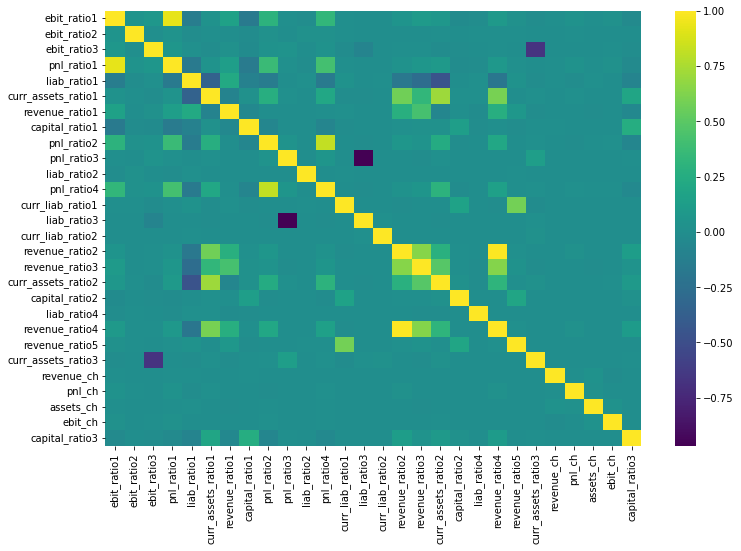

In [120]:
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(df.loc[:, df.columns.str.contains('ratio|ch')].dropna().apply(pd.to_numeric).corr(), cmap='viridis')

In [ ]:
df.groupby('Inactive')['ebit_ratio2'].describe()

In [140]:
# NAs share among original variables
(df.loc[:, ~df.columns.str.contains('ratio|ch|sector_|lag')].isna().sum() / df.shape[0]).sort_values(ascending=False)[:10]

revenue         0.171048
lt_debt         0.079032
cash            0.045801
capital         0.010818
sector          0.005318
ebit            0.000120
fixed_assets    0.000012
assets_log      0.000004
assets          0.000004
CY              0.000000
dtype: float64

In [71]:
split_share = 0.8

rnd.seed(1)
train_id = rnd.sample(range(df.shape[0]), round(df.shape[0] * split_share))

train_df = df.drop(['country', 'last_year', 'sector'], axis=1).loc[train_id]
test_df  = df.drop(['country', 'last_year', 'sector'], axis=1).loc[~np.isin(list(range(df.shape[0])), train_id)]

In [72]:

# univariate imputing with train dataset median of given variable. 
for variable in train_df.loc[:, train_df.apply(lambda x: any(x.isna()))].columns:
    train_df.loc[train_df[variable].isna(), variable] = train_df[variable].median()
    test_df.loc[test_df[variable].isna(), variable] = test_df[variable].median()

# idea to implement: multivariate LM imputing based on no NAs variable

In [73]:
rnd.seed(1)

def undersampling(df, class_variable, rate):
    indexes = rnd.sample(list(df[df[class_variable] == 0].index), k = round(np.sum(df[class_variable] == 1) * rate))
    train_df = pd.concat([df.loc[df[class_variable] == 1], df.loc[indexes]])
    return train_df

df_train_us = undersampling(train_df, 'Inactive', 1) # undersampling to 1:1 relation
df_train_sm = undersampling(train_df, 'Inactive', 3) # undersampling to 2:1 relation for SMOTE
X_train_us = df_train_us.loc[:, df_train_us.columns != 'Inactive']
y_train_us = df_train_us.Inactive

In [74]:
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(df_train_sm.loc[:,~np.isin(df_train_sm.columns, 'Inactive')], df_train_sm['Inactive'])

In [75]:
rnd.seed(1)

os_indexes = rnd.choices(list(train_df[train_df.Inactive == 1].index), k = np.sum(train_df.Inactive == 0) - np.sum(train_df.Inactive == 1))
train_df_os = pd.concat([train_df.loc[os_indexes,:], train_df])

X_train_os = train_df_os.loc[:, train_df_os.columns != 'Inactive']
y_train_os = train_df_os.Inactive

In [76]:
{'SMOTE n observations': y_train_sm.shape[0],
 'Undersampling n observations': y_train_us.shape[0],
 'Oversampling n observations': y_train_os.shape[0]}


{'SMOTE n observations': 32136,
 'Undersampling n observations': 10712,
 'Oversampling n observations': 423850}

In [77]:
#%run -i models/logistic_regression.py 
# approx time: 45 mins

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 1/3] END ............C=0.0001, l1_ratio=0.0;, score=0.539 total time=   1.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END ............C=0.0001, l1_ratio=0.0;, score=0.538 total time=   1.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END ............C=0.0001, l1_ratio=0.0;, score=0.548 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END ............C=0.0001, l1_ratio=0.5;, score=0.539 total time=   1.9s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END ............C=0.0001, l1_ratio=0.5;, score=0.538 total time=   1.6s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 3/3] END ............C=0.0001, l1_ratio=0.5;, score=0.548 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END ............C=0.0001, l1_ratio=1.0;, score=0.539 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 2/3] END ............C=0.0001, l1_ratio=1.0;, score=0.539 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 3/3] END ............C=0.0001, l1_ratio=1.0;, score=0.548 total time=   1.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 1/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.539 total time=   1.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.538 total time=   1.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.548 total time=   1.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 1/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.538 total time=   1.6s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.539 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.548 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.539 total time=   2.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.538 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.548 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.539 total time=   1.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.539 total time=   1.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 3/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.548 total time=   1.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.539 total time=   2.0s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.539 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.548 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 1/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.539 total time=   2.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.539 total time=   1.6s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 3/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.548 total time=   1.9s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.539 total time=   2.0s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.539 total time=   1.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.548 total time=   1.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.539 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 2/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.539 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 1 seconds
[CV 3/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.548 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 1/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.539 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 2/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.539 total time=   1.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 2 seconds
[CV 3/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.548 total time=   1.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 52 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.1s finished


[CV 1/3] END ............C=0.0001, l1_ratio=0.0;, score=0.590 total time=  56.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 53 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   53.2s finished


[CV 2/3] END ............C=0.0001, l1_ratio=0.0;, score=0.527 total time=  58.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 52 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s finished


[CV 3/3] END ............C=0.0001, l1_ratio=0.0;, score=0.593 total time=  56.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 72 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 1/3] END ............C=0.0001, l1_ratio=0.5;, score=0.590 total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 79 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 2/3] END ............C=0.0001, l1_ratio=0.5;, score=0.527 total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 62 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished


[CV 3/3] END ............C=0.0001, l1_ratio=0.5;, score=0.593 total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 57 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.3s finished


[CV 1/3] END ............C=0.0001, l1_ratio=1.0;, score=0.590 total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 57 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.6s finished


[CV 2/3] END ............C=0.0001, l1_ratio=1.0;, score=0.527 total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 68 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 3/3] END ............C=0.0001, l1_ratio=1.0;, score=0.593 total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 55 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.6s finished


[CV 1/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.590 total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 49 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.3s finished


[CV 2/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.527 total time=  53.5s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 56 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.3s finished


[CV 3/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.593 total time=  59.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 66 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 1/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.590 total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 68 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 2/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.527 total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 67 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 3/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.593 total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 78 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 1/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.590 total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 74 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 2/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.527 total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 83 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


[CV 3/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.593 total time= 1.5min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 54 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.6s finished


[CV 1/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.590 total time=  58.9s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 50 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.9s finished


[CV 2/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.527 total time=  54.1s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 58 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.0s finished


[CV 3/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.593 total time= 1.0min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 70 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 1/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.590 total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 65 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 2/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.527 total time= 1.2min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 60 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   60.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   60.0s finished


[CV 3/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.593 total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 61 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished


[CV 1/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.590 total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 64 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min finished


[CV 2/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.527 total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 74 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 3/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.593 total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 50 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   49.6s finished


[CV 1/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.590 total time=  53.7s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 46 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   45.9s finished


[CV 2/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.527 total time=  50.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 48 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.3s finished


[CV 3/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.593 total time=  51.4s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 72 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 1/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.590 total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 76 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 2/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.527 total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 81 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 3/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.593 total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 78 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


[CV 1/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.590 total time= 1.4min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 73 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished


[CV 2/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.527 total time= 1.3min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 63 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min finished


[CV 3/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.593 total time= 1.1min


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 71 seconds
Fitting 3 folds for each of 12 candidates, totalling 36 fits


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 1/3] END ............C=0.0001, l1_ratio=0.0;, score=0.576 total time=   4.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 2/3] END ............C=0.0001, l1_ratio=0.0;, score=0.531 total time=   4.0s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 3/3] END ............C=0.0001, l1_ratio=0.0;, score=0.568 total time=   3.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END ............C=0.0001, l1_ratio=0.5;, score=0.576 total time=   4.1s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 2/3] END ............C=0.0001, l1_ratio=0.5;, score=0.530 total time=   4.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 3/3] END ............C=0.0001, l1_ratio=0.5;, score=0.568 total time=   4.0s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END ............C=0.0001, l1_ratio=1.0;, score=0.576 total time=   4.1s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 2/3] END ............C=0.0001, l1_ratio=1.0;, score=0.531 total time=   4.0s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 3/3] END ............C=0.0001, l1_ratio=1.0;, score=0.568 total time=   4.0s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.576 total time=   3.9s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 2/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.531 total time=   3.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 3/3] END C=0.046415888336127774, l1_ratio=0.0;, score=0.568 total time=   3.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 1/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.576 total time=   4.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 2/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.531 total time=   4.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 3/3] END C=0.046415888336127774, l1_ratio=0.5;, score=0.568 total time=   4.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.576 total time=   4.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 2/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.530 total time=   4.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 3/3] END C=0.046415888336127774, l1_ratio=1.0;, score=0.569 total time=   4.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 1/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.576 total time=   3.3s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 2/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.531 total time=   3.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 3/3] END .C=21.54434690031882, l1_ratio=0.0;, score=0.568 total time=   3.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 1/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.576 total time=   4.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 2/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.530 total time=   4.6s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 3/3] END .C=21.54434690031882, l1_ratio=0.5;, score=0.569 total time=   4.8s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.576 total time=   4.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 2/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.531 total time=   4.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 3/3] END .C=21.54434690031882, l1_ratio=1.0;, score=0.569 total time=   4.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 1/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.576 total time=   3.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 2/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.531 total time=   3.2s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 3 seconds
[CV 3/3] END ...........C=10000.0, l1_ratio=0.0;, score=0.568 total time=   3.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.576 total time=   4.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 2/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.531 total time=   4.6s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 3/3] END ...........C=10000.0, l1_ratio=0.5;, score=0.569 total time=   4.7s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 1/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.576 total time=   4.5s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 4 seconds
[CV 2/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.531 total time=   4.6s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
[CV 3/3] END ...........C=10000.0, l1_ratio=1.0;, score=0.568 total time=   4.4s


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 7 seconds


c:\Users\HP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.5s finished


In [122]:
#%run -i models/mlpc.py
# approx time: 47 mins

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50, 20), learning_rate=adaptive, solver=sgd; total time=   9.3s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50, 20), learning_rate=adaptive, solver=sgd; total time=  10.7s
[CV] END activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50, 20), learning_rate=adaptive, solver=sgd; total time=   7.9s
[CV] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd; total time=   8.7s
[CV] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd; total time=   8.7s
[CV] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd; total time=   8.7s
[CV] END activation=tanh, alpha=0.005, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam; total time=   2.2s
[CV] END activation=tanh, alpha=0.005, hidden_

In [124]:
#%run -i models/xgb.py
# approx. time: 38 mins

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   2.4s
[CV] END colsample_bytree=0.8, gamma=1, max_depth=3, min_child_weight=10, subsample=0.6; total time=   2.5s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.8; total time=   2.2s
[CV] END colsample_bytree=0.6, gamma=1.5, max_depth=4, min_child_weight=1, subsample=0.8; total time=   1.9s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10, subsample=0.6; total time=   3.4s
[CV] END colsample_bytree=0.6, gamma=2, max_depth=5, min_child_weight=10,

In [125]:
# this code chunk loads pretraiend models
# if you wish to train them once again run code chunks above
logit_os = joblib.load('models/logit_os.sav')
logit_us = joblib.load('models/logit_us.sav')
logit_sm = joblib.load('models/logit_sm.sav')

mlpc_us = joblib.load('models/mlpc_us.sav')
mlpc_os = joblib.load('models/mlpc_os.sav')
mlpc_sm = joblib.load('models/mlpc_sm.sav')

xgb_us = joblib.load('models/xgb_us.sav')
xgb_os = joblib.load('models/xgb_os.sav')
xgb_sm = joblib.load('models/xgb_sm.sav')

In [126]:
%run -i "src/pred_metrics_class.py"

In [127]:
ml_models = {
    'logit_os': logit_os,
    'logit_us': logit_us,
    'logit_sm': logit_sm,
    'xgb_us': xgb_us,
    'xgb_os': xgb_os,
    'xgb_sm': xgb_sm,
    'mlpc_us': mlpc_us,
    'mlpc_os': mlpc_os,
    'mlpc_sm': mlpc_sm
}

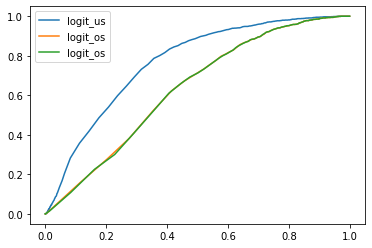

In [11]:
metrics_logit_us = PredMetrics(pred_pd = logit_us.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_os = PredMetrics(pred_pd = logit_os.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))
metrics_logit_sm = PredMetrics(pred_pd = logit_sm.predict_proba(test_df.loc[:,test_df.columns != 'Inactive'])[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['logit_us', 'logit_os', 'logit_sm']
n = 0

for model in [metrics_logit_us, metrics_logit_os, metrics_logit_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n =+ 1

plt.legend()
plt.show()

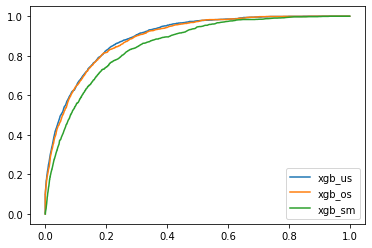

In [12]:
metrics_xgb_us = PredMetrics(pred_pd = xgb_us.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_os = PredMetrics(pred_pd = xgb_os.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_xgb_sm = PredMetrics(pred_pd = xgb_sm.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['xgb_us', 'xgb_os', 'xgb_sm']
n = 0

for model in [metrics_xgb_us, metrics_xgb_os, metrics_xgb_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.show()

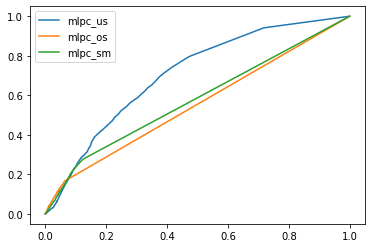

In [13]:
metrics_mlpc_us = PredMetrics(pred_pd = mlpc_us.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_os = PredMetrics(pred_pd = mlpc_os.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))
metrics_mlpc_sm = PredMetrics(pred_pd = mlpc_sm.predict_proba(np.array(test_df.loc[:,test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

labels = ['mlpc_us', 'mlpc_os', 'mlpc_sm']
n = 0

for model in [metrics_mlpc_us, metrics_mlpc_os, metrics_mlpc_sm]:
    fpr = [model.fpr(i) for i in thresholds]
    tpr = [model.tpr(i) for i in thresholds]
    plt.plot(fpr, tpr, label = labels[n])
    n += 1

plt.legend()
plt.show()

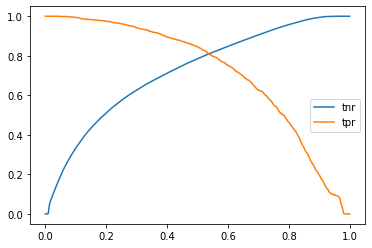

In [14]:
metrics = PredMetrics(pred_pd = xgb_us.predict_proba(np.array(test_df.iloc[:, test_df.columns != 'Inactive']))[:,1],
                       actual = np.array(test_df.Inactive))

thresholds = np.linspace(start=0, stop=1, num=1000)

tnr = [metrics.tnr(i) for i in thresholds]
tpr = [metrics.tpr(i) for i in thresholds]

plt.plot(thresholds, tnr, label = "tnr")
plt.plot(thresholds, tpr, label = "tpr")
plt.legend()
plt.show()

In [15]:
metrics.max_balanced_acc(granularity = 1000)

thresholds      0.497497
tpr             0.847639
tnr             0.783186
balanced_acc    0.815413
Name: 497, dtype: float64